In [198]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Parameters

In [322]:
global_config = {}

global_config['num_samples'] = 1000
global_config['num_features'] = 5
global_config['num_experiments'] = 5

# Delta (measure for imbalance of treatment assigment)
# delta = 0 --> P(w=1 | X) = 0.5
# The greater delta, the higher the portion of treated patients
global_config['delta'] = 0.3 # = np.linspace(0, 1, num=10)


# Sigma (measure of how similar the two outcomes are)
# sigma = 0 --> outcomes have maximum similarity
# The greater sigma, the more different the outcomes are
global_config['sigma'] = 1.0 


# Alpha
# controls the similarity between the outcomes (namely the second part linear vs. quadratic)
global_config['alpha0'] = 1.0
global_config['alpha1'] = 1.0

### Helper Functions

In [323]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

# Outcome 0
def f0(x, b0, a0, g0):
    # Linear (X * g0)
    return np.dot(X, b0) + a0 * np.exp(np.dot(X, g0))

# Outcome 1
def f1(x, b1, a1, g1):
    # Quadratic  (X * (g1*g1))
    return np.dot(X, b1) + a1 * np.exp(np.dot(X, g1 * g1))

### Generate Data

In [324]:
def draw_data(N, D, alphas, sigma, delta, X=None):
    # Features
    if X is None:
        X = np.random.uniform(low=0.0, high=1.0, size=[N, D])
        
    # Treatment Assignment (imbalance depending on delta)
    treatment_probability = sigmoid(delta * np.sum(X, axis=1))
    T = np.random.binomial(n=1, p=treatment_probability)
    
    # Draw Parameters
    beta1 = np.random.choice([0, 0.1, 0.2, 0.3, 0.4], size=D, replace=True, p=[0.6, 0.1, 0.1, 0.1,0.1])
    beta0 = np.random.normal(loc=beta1, scale=sigma)
    gamma1 = np.random.choice([0, 0.1, 0.2, 0.3, 0.4], size=D, replace=True, p=[0.6, 0.1, 0.1, 0.1,0.1])
    gamma0 = np.random.normal(loc=gamma1, scale=sigma)
    
    # Outcomes
    Y0 = f0(X, beta0, alphas[0], gamma0) + np.random.normal(loc=0.0, scale=1.0, size=N)
    Y1 = f1(X, beta1, alphas[1], gamma1) + np.random.normal(loc=0.0, scale=1.0, size=N)
    
    # Convert to DataFrame
    X_df = pd.DataFrame(X, columns=['X{}'.format(i) for i in range(D)])
    T_df = pd.DataFrame(T, columns=['T'])
    Y0_df = pd.DataFrame(Y0, columns=['Y0'])
    Y1_df = pd.DataFrame(Y1, columns=['Y1'])
    return pd.concat([X_df, T_df, Y0_df, Y1_df], axis=1)
    

In [325]:
# Keep covariates fixed across all experiments
X = np.random.uniform(low=0.0, high=1.0, size=[global_config['num_samples'], 
                                               global_config['num_features']])

for experiment_id in range(num_experiments):
    data = draw_data(global_config['num_samples'], 
                     global_config['num_features'], 
                     alphas=[global_config['alpha0'], global_config['alpha1']], 
                     sigma=global_config['sigma'], 
                     delta=global_config['delta'],
                     X=X)
    print(data.head(n=2))

        X0        X1        X2        X3        X4  T        Y0        Y1
0  0.83870  0.831262  0.264155  0.738776  0.785354  0  4.608120  3.866695
1  0.81432  0.418329  0.953985  0.468292  0.398643  1  5.322528  3.173472
        X0        X1        X2        X3        X4  T        Y0        Y1
0  0.83870  0.831262  0.264155  0.738776  0.785354  1  1.974484  1.234654
1  0.81432  0.418329  0.953985  0.468292  0.398643  1  0.186798  1.097673
        X0        X1        X2        X3        X4  T        Y0        Y1
0  0.83870  0.831262  0.264155  0.738776  0.785354  1  2.338402  1.781791
1  0.81432  0.418329  0.953985  0.468292  0.398643  1  1.651494  3.059807
        X0        X1        X2        X3        X4  T        Y0        Y1
0  0.83870  0.831262  0.264155  0.738776  0.785354  1  4.319185  0.313083
1  0.81432  0.418329  0.953985  0.468292  0.398643  1  2.967771  0.808940
        X0        X1        X2        X3        X4  T        Y0        Y1
0  0.83870  0.831262  0.264155  0.7387

## Explore Data and Parameters

In [326]:
# Keep covariates fixed across all experiments
X = np.random.uniform(low=0.0, high=1.0, size=[global_config['num_samples'], 
                                               global_config['num_features']])

### Delta (Imbalance regarding Treatment Assignment)

In [328]:
deltas = np.linspace(0, 2, num=5)
for delta in deltas:
    data = draw_data(global_config['num_samples'], 
                 global_config['num_features'], 
                 alphas=[global_config['alpha0'], global_config['alpha1']], 
                 sigma=global_config['sigma'], 
                 delta=delta,
                 X=X)
    p_treated = np.mean(data['T'], axis=0)
    print('Delta: {:.4f}\t p(treated)={:.4f}'.format(delta, p_treated))
    

Delta: 0.0000	 p(treated)=0.4940
Delta: 0.5000	 p(treated)=0.7780
Delta: 1.0000	 p(treated)=0.9180
Delta: 1.5000	 p(treated)=0.9730
Delta: 2.0000	 p(treated)=0.9860


### Sigma

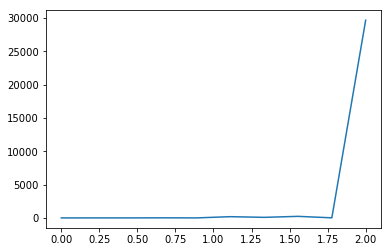

In [321]:
sigmas = np.linspace(0, 2, num=10)
ATEs = []
for sigma in sigmas:
    data = draw_data(global_config['num_samples'], 
                 global_config['num_features'], 
                 alphas=[global_config['alpha0'], global_config['alpha1']], 
                 sigma=sigma, 
                 delta=global_config['delta'],
                 X=X)
    
    ATE = np.mean(np.abs(data['Y0'] - data['Y1']))
    ATEs.append(ATE)
    #print('Sigma: {:.4f}\t ATE={:.4f}'.format(sigma, ATE))

plt.plot(sigmas, ATEs)
plt.show()
    

In [273]:
np.mean(data['Y0'] - data['Y1'])

0.35869065229595681